**背景:** 
  
1. 学习tensorflow并动手实践的第一步：用[Keras functional API](https://www.tensorflow.org/guide/keras/functional)搭建简单的[DIN](https://paperswithcode.com/paper/deep-interest-network-for-click-through-rate)模型，在demo数据集上调通。
2. 简化deepctr里的实现方式，只保留重要的主干部分，帮助理解模型结构。

**所以暂不不涉及以下：**
- mask
- 真实数据
- 代码模块化
- tensorboard
- log
- GPU和分布式训练

## 准备工作

设置markdown的表格居左对齐。

In [1]:
%%html
<style>
table {float:left}
</style>

## 导入模块

In [2]:
import tensorflow as tf 
print("TensorFlow version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np 

TensorFlow version: 2.4.1


## 模拟数据
  


模拟数据中user和item feature。包含sparse、dense和seq；其中seq将和相应的item共享embedding。  


user feat     | type   | item feat   | type    
 :--- | ---: | :---  | ---:    
 uid           | sparse | item_id    | sparse 
 gender        | sparse | cate_id    | sparse 
 pay_score     | dense  |            |        
 hist_item_id  | seq    |            |        
 hist_cate_id  | seq    |            |  

In [3]:
def generate_xy():
    uid = np.array([0, 1, 2])
    gender = np.array([0, 1, 0])
    item_id = np.array([1, 2, 3]) 
    cate_id = np.array([1, 2, 2])
    pay_score = np.array([0.1, 0.2, 0.3])

    hist_item_id = np.array([[1, 2, 3, 2], [3, 2, 1, 2], [1, 2, 1, 3]])
    hist_cate_id = np.array([[1, 2, 2, 1], [2, 2, 1, 1], [1, 2, 1, 1]])

    x = {'uid': uid, 'gender': gender, 'item_id': item_id, 'cate_id': cate_id,
            'hist_item_id': hist_item_id, 'hist_cate_id': hist_cate_id, 'pay_score': pay_score}
    y = np.array([1, 0, 1])
    return x, y

x, y = generate_xy() 

## 构建模型

（注：这里有很多重复的代码量，这个notebook不做模块化的优化。）

- 总结下可以预先定义的重要属性有：  
    feature_name、dtype、embedding_size、vocabulary_size、embedding_name、use_hash、max_len 
    
    
- keras functional API 可以参照这个[官方教程](https://www.tensorflow.org/guide/keras/functional#manipulate_complex_graph_topologies)。

### 定义input layer

In [4]:
num_item_id = 3 
num_cate_id = 2 
max_len = 4

# 除了seq外，shape都是(1,)；seq的shape是(max_len,)
uid_input = keras.Input(shape=(1,), name="uid", dtype="int64")
gender_input = keras.Input(shape=(1,), name="gender", dtype="int64")
pay_score_input = keras.Input(shape=(1,), name="pay_score", dtype="float32")

item_id_input = keras.Input(shape=(1,), name="item_id", dtype="int64")
cate_id_input = keras.Input(shape=(1,), name="cate_id", dtype="int64")

hist_item_id_input = keras.Input(shape=(max_len,), name="hist_item_id", dtype="int64")
hist_cate_id_input = keras.Input(shape=(max_len,), name="hist_cate_id", dtype="int64")

inputs = [uid_input, gender_input, pay_score_input, 
          item_id_input, cate_id_input, hist_item_id_input, hist_cate_id_input]

### 定义(seq) sparse特征的embedding

需要注意的是，sparse特征和seq sparse特征通过同样的embedding_name来共享 (share) embedding.

In [5]:
uid_emb = layers.Embedding(input_dim = 100, output_dim = 8, name='uid_emb')(uid_input)
gender_emb = layers.Embedding(input_dim = 2, output_dim = 4, name='gender_emb')(gender_input)

2023-05-26 22:58:05.215127: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-26 22:58:05.215377: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# 实现share embedding 
item_id_share_emb = layers.Embedding(input_dim = num_item_id + 1, output_dim = 8, name='item_id_emb')
cate_id_share_emb = layers.Embedding(input_dim = num_cate_id + 1, output_dim = 4, name='cate_id_emb')

item_id_emb = item_id_share_emb(item_id_input)
cate_id_emb = cate_id_share_emb(cate_id_input)

hist_item_id_emb = item_id_share_emb(hist_item_id_input)
hist_cate_id_emb = cate_id_share_emb(hist_cate_id_input)

### attention实现

这个demo里用hist_item_id对item_id做attention（即din部分）；hist_cate_id视为普通序列特征，后续经过pooling后和其他emb拼接。  

In [7]:
## 计算attention分数
seq_len = hist_item_id_emb.get_shape()[1]
queries = K.repeat_elements(item_id_emb, seq_len, 1)

att_input = tf.concat([queries, hist_item_id_emb, 
                       queries - hist_item_id_emb, 
                       queries * hist_item_id_emb], axis=-1)

att_output = layers.Dense(32, activation='relu')(att_input)
att_output = layers.Dense(1, activation='relu')(att_output)
attention_score = tf.transpose(att_output, (0, 2, 1))

In [8]:
## hist_item_id_emd特征加权pooling
attention_output = tf.matmul(attention_score, hist_item_id_emb)

In [9]:
## hist_cate_id特征sum pooling
hist_cate_id_emb = tf.reduce_mean(hist_cate_id_emb, 1, keepdims=True)

### concat目前为止的所有特征

In [10]:
all_deep_input = tf.concat([uid_emb, gender_emb, tf.expand_dims(pay_score_input, 2),
                           item_id_emb, cate_id_emb, hist_cate_id_emb, attention_output], axis=2)

### 添加后续mlp 完成model

In [11]:
all_deep_ouput = layers.Dense(64, activation='relu')(all_deep_input)
all_deep_ouput = layers.Dense(32, activation='relu')(all_deep_ouput)

output = layers.Dense(1, activation='relu')(all_deep_ouput)

model = keras.Model(
    inputs=inputs,
    outputs=output)

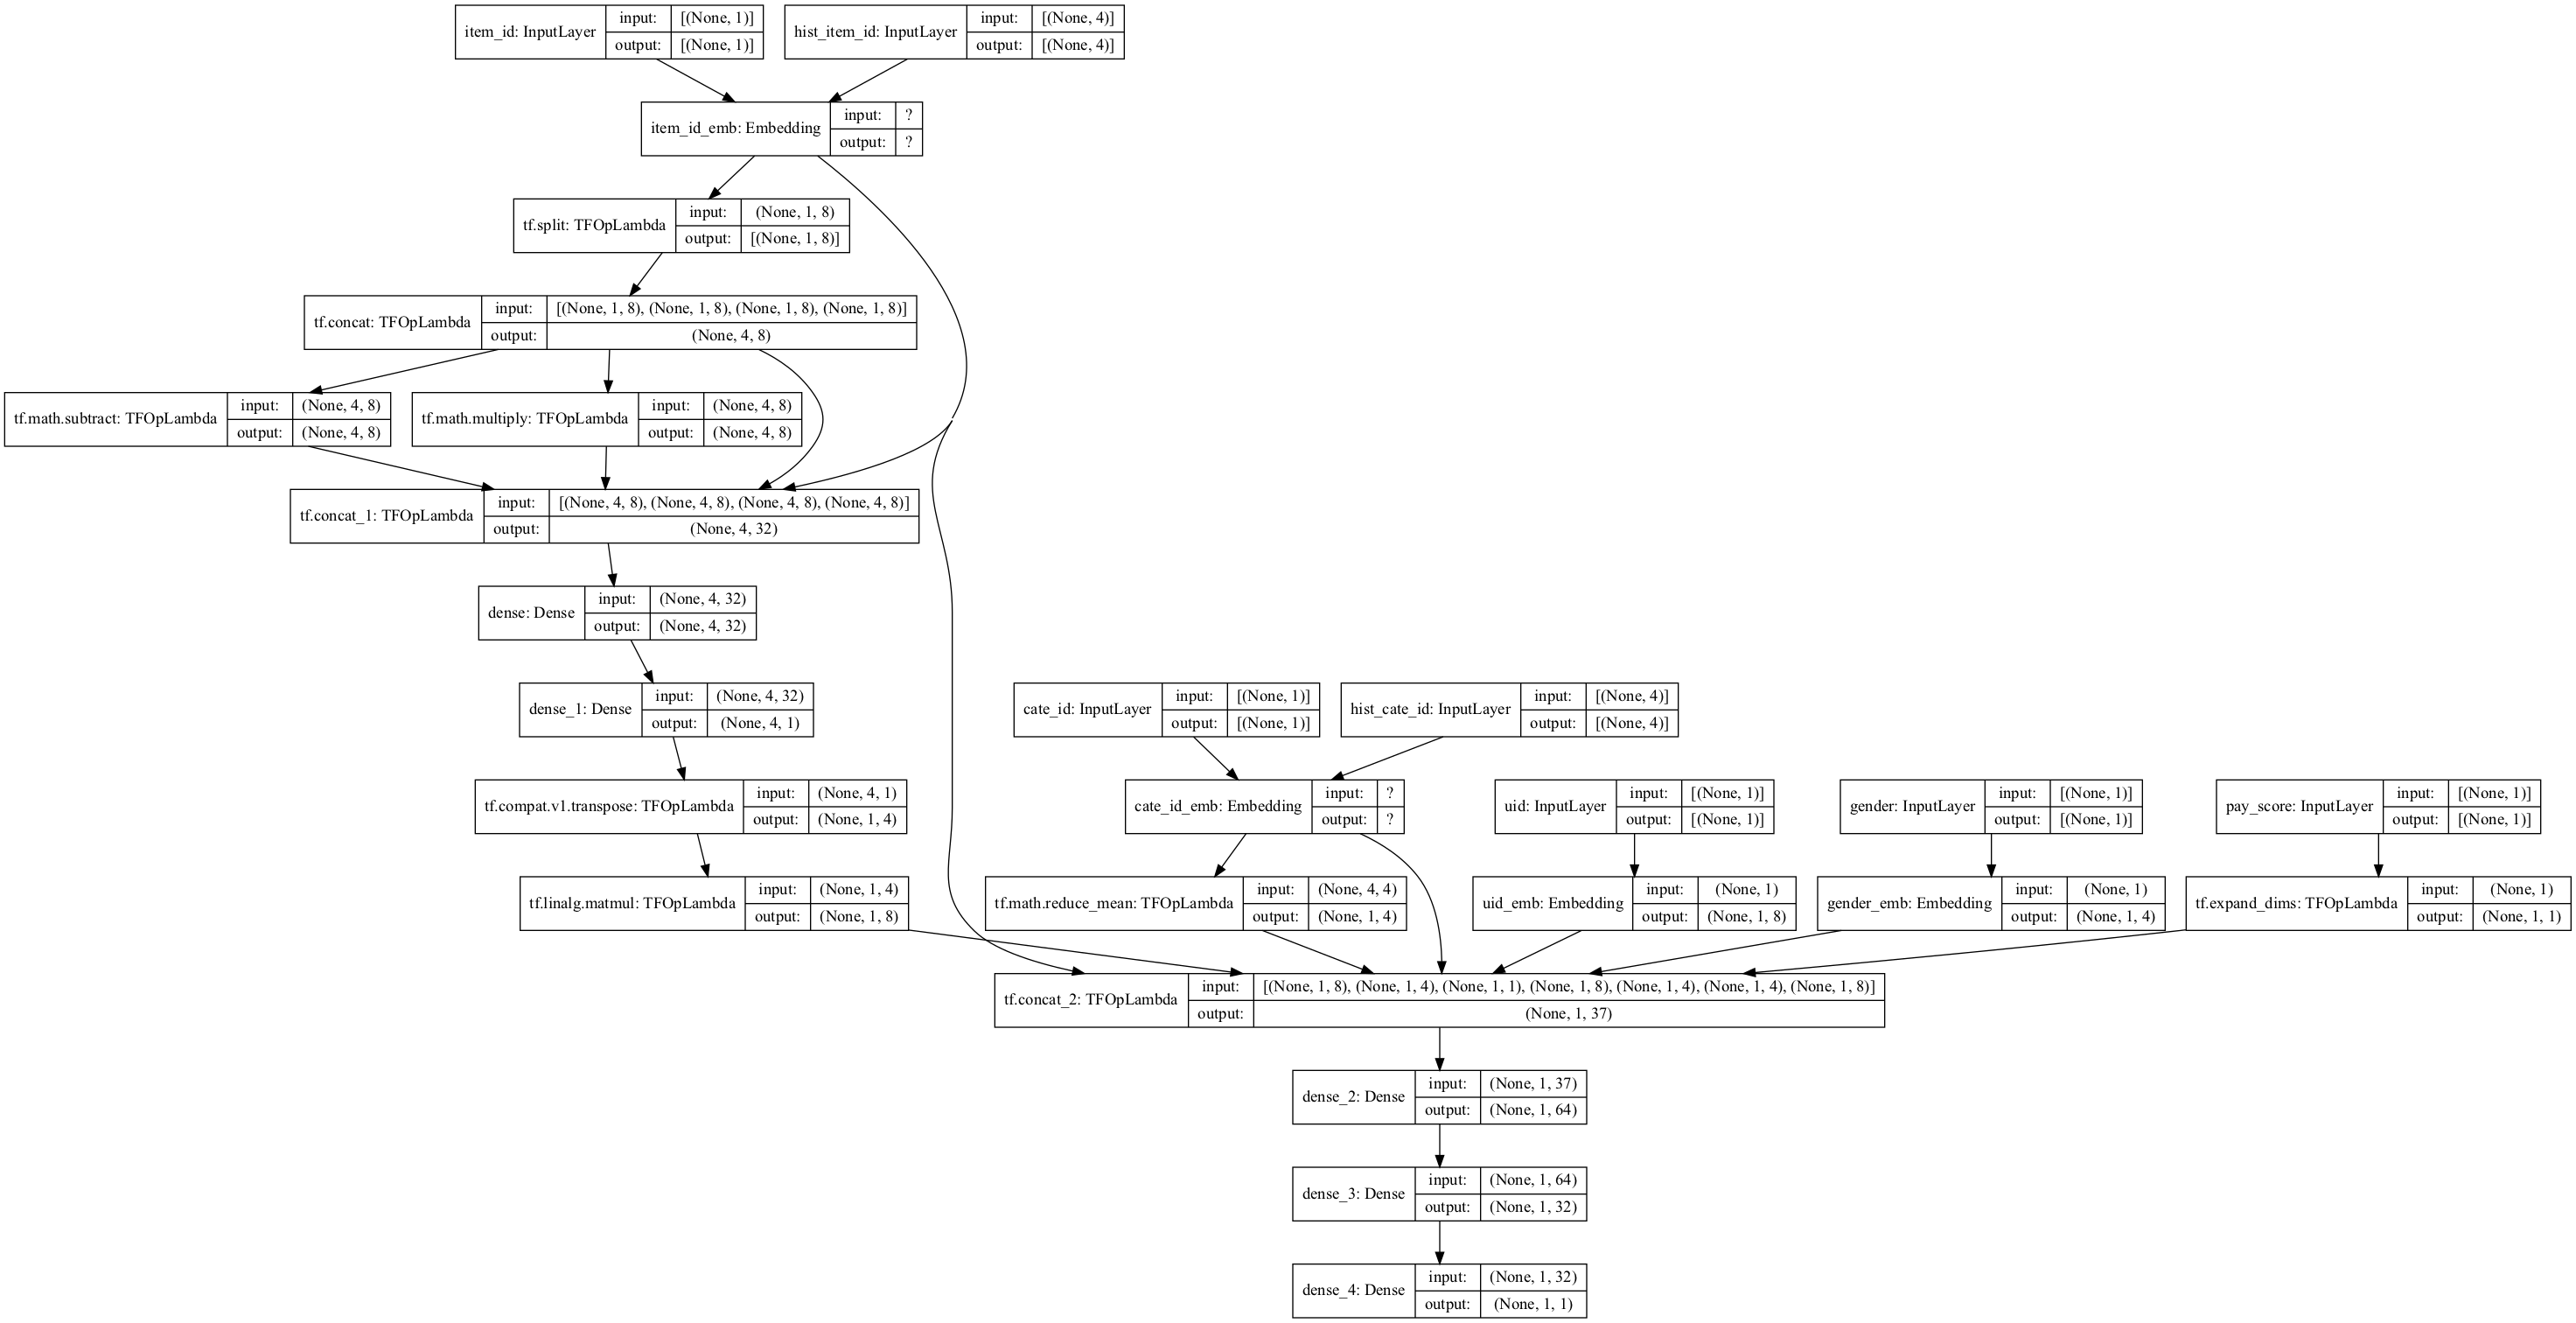

In [12]:
keras.utils.plot_model(model, "simple_din_model.png", show_shapes=True)

## fit model 

因为是仅包含3个样本的demo数据，这里只测试能不能跑通。

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

model.fit(x, y,
        epochs=1,
        batch_size=1,
        verbose=0)

2023-05-26 22:58:05.629874: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
